# Modeling

In this notebook I will build **models to predict the student course outcome.** In previous notebook **EDA** I've performed the **exploratory analysis and built some visualizations**. At the end the new dataset was stored as "final_data.csv" file in data folder.

## Goal of the Modeling
The main goal of the project is to be able to predict the outcome of the students in the course. I will build different algorithms of **multiclass classification models and evaluate their performance**. At the end of the notebook I will choose a model that has the **most appropriate parameters and performed the best.**

## Import Packages

Import standard libraries and necessary packages for transformation, modeling and evaluation. In addition, import **WHAT!!!!!!!!!!!!!!** functions and classess.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

#from sklearn.decomposition import PCA
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

from sklearn.linear_model import LogisticRegression as LR
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import RandomForestClassifier as RFC, GradientBoostingClassifier as GBC
from sklearn.cluster import KMeans
from xgboost import XGBClassifier as XGB


from sklearn.metrics import plot_confusion_matrix
#from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc


# Import additional files with statistical functions
import sys
import os

module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import explore_data as ed 
import model_functions as mf
import model_history as mh

* Set notebook's visual parameters

In [2]:
pd.options.display.max_rows = 500
pd.options.display.max_columns = 100

plt.style.use('seaborn-dark')
sns.set_theme('talk')

## Upload Dataset

Upload final_data.csv from data folder, keep id_student feature as object type.

In [3]:
df = pd.read_csv('../data/final_data.csv', dtype={"id_student": str})

In [4]:
df.columns

Index(['module_presentation_length', 'code_module', 'code_presentation',
       'id_student', 'date_registration', 'sum_click', 'gender', 'region',
       'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts',
       'studied_credits', 'disability', 'final_result', 'mean_score'],
      dtype='object')

In [5]:
ed.show_info(df)

Lenght of Dataset: 20224
                            missing_values_% Data_type
module_presentation_length               0.0     int64
code_module                              0.0    object
code_presentation                        0.0    object
id_student                               0.0    object
date_registration                        0.0     int64
sum_click                                0.0     int64
gender                                   0.0    object
region                                   0.0    object
highest_education                        0.0    object
imd_band                                 0.0    object
age_band                                 0.0    object
num_of_prev_attempts                     0.0     int64
studied_credits                          0.0     int64
disability                               0.0    object
final_result                             0.0    object
mean_score                               0.0   float64


* I will drop columns that are not relevant to modeling, such that id_student and code_presentation

In [6]:
df.drop(columns = ['id_student', 'code_presentation'], inplace = True)

In [7]:
df.rename(columns = {'module_presentation_length': 'course_length', 
                     'num_of_prev_attempts': 'attempts'}, inplace = True)
df.head()

,course_length,code_module,date_registration,sum_click,gender,region,highest_education,imd_band,age_band,attempts,studied_credits,disability,final_result,mean_score
0,262,DDD,88,458,M,North Western Region,Lower Than A Level,0-10%,0-35,0,60,N,Pass,86.50
1,262,DDD,136,1107,M,Scotland,HE Qualification,80-90%,55<=,0,60,N,Pass,80.00
2,262,DDD,107,663,M,West Midlands Region,A Level or Equivalent,90-100%,0-35,0,60,N,Pass,86.00
3,262,DDD,99,729,M,East Anglian Region,A Level or Equivalent,80-90%,0-35,0,90,N,Fail,65.25
4,262,DDD,143,453,F,South Region,A Level or Equivalent,40-50%,0-35,0,60,Y,Pass,87.50


## Features

* **course_length:** length of the code_module in days.
* **code_module:** three letter id of the course.
* **date_registration:** number of days student registered before the course beginning.
* **sum_click:** sum of click student made on Vle for given course.
* **gender:** gender of the student.
* **region:** region of student location in UK.
* **highest_education:** education level of the student.
* **imd_band:** indices of multiple deprivation - a measure of economic status.
* **age_band:** age category of the student.
* **attempts:** number of times the student has attempted the class.
* **disability:** disability status of the student.
* **studied credits:** number of credits student acquired by the begginning of the course.
* **mean_score:** The student's mean assessment score.


### Binarize Classes

* For the purpose of modeling, I will binarize the target labels, such that Fail/Withdraw - 1, and Pass/Distinc - 0.

In [9]:
df['final_result'] = df['final_result'].apply(lambda x: 0 if ('Pass' in x or 'Distinct' in x ) else 1)
df['final_result'].value_counts()

0    14628
1     5596
Name: final_result, dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20224 entries, 0 to 20223
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   course_length      20224 non-null  int64  
 1   code_module        20224 non-null  object 
 2   date_registration  20224 non-null  int64  
 3   sum_click          20224 non-null  int64  
 4   gender             20224 non-null  object 
 5   region             20224 non-null  object 
 6   highest_education  20224 non-null  object 
 7   imd_band           20224 non-null  object 
 8   age_band           20224 non-null  object 
 9   attempts           20224 non-null  int64  
 10  studied_credits    20224 non-null  int64  
 11  disability         20224 non-null  object 
 12  final_result       20224 non-null  int64  
 13  mean_score         20224 non-null  float64
dtypes: float64(1), int64(6), object(7)
memory usage: 2.2+ MB


## Feature Correlation

Explore how correlated numeric features are.

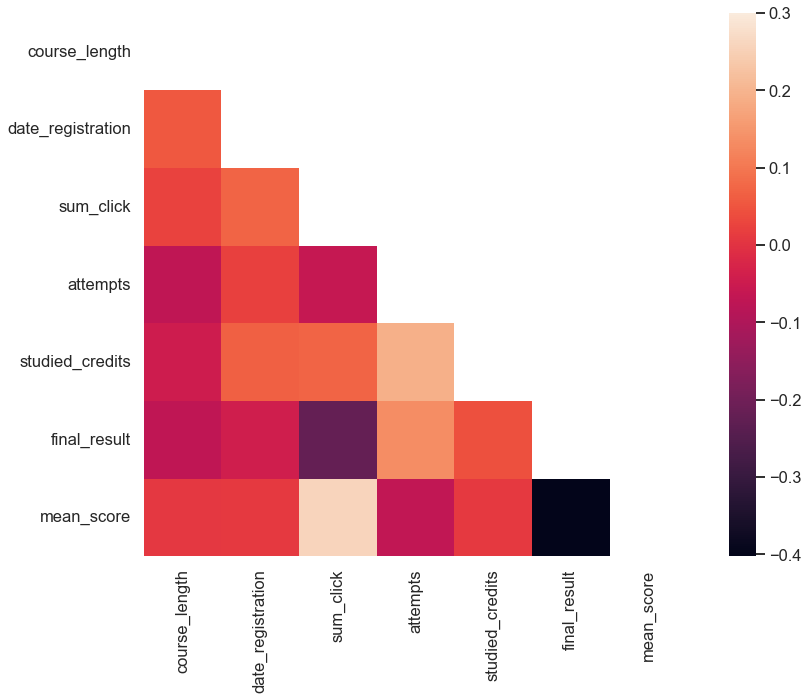

In [11]:
corr = df.corr(method = 'pearson')

mask = np.triu(np.ones_like(corr, dtype='bool'))

with sns.axes_style("white"):
    f,ax = plt.subplots(figsize = (15,10))
    ax = sns.heatmap(corr, mask = mask, vmax = 0.3, square = True)

In [12]:
corr_matrix = df.corr()
corr_mat = corr_matrix["final_result"].sort_values(ascending=False)
print(corr_mat)

final_result         1.000000
attempts             0.132633
studied_credits      0.044604
date_registration   -0.042975
course_length       -0.072593
sum_click           -0.220464
mean_score          -0.402654
Name: final_result, dtype: float64


### Train-Test Split

To prevent models from **overfitting** and to be able to **accurately evaluate model** I will split the data to **X as a features and y as a target variable, and split data into three sets: train, test and holdout.**

In [13]:
X = df.drop("final_result", axis=1)
y = df['final_result']

Now, split the data to **train and holdout sets** and then **split the train set into test and train sets too.**

In [14]:
x_all, x_hold, y_all, y_hold = train_test_split(X, y, train_size = 0.80, random_state=2021)
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, train_size = 0.75,random_state=2021)

### Data Imbalance

I will check how balanced my train data is based on target feature

In [15]:
pd.Series(y_train).value_counts(normalize=True)

0    0.720949
1    0.279051
Name: final_result, dtype: float64

* It is clear that train set is imbalanced. I will build first model with this data and later on try to balance it using SMOTE.

## Baseline Model - Logistic Regression

### ColumnTransformer for Categorical Features

Before I start any modeling, I will use **ColumnTransformer and OneHotEncode** all categorical features of the dataframe:

In [16]:
cat_cols = x_train.select_dtypes(include='object').columns
indices = []
for col in cat_cols:
    indices.append(x_train.columns.get_loc(col))
indices

[1, 4, 5, 6, 7, 8, 11]

In [17]:
transformer = ColumnTransformer(transformers=[('categorical', 
                                               OneHotEncoder(handle_unknown = 'ignore'), indices)])

### Build a Pipeline

In [18]:
categ_pipeline = make_pipeline(transformer, StandardScaler(with_mean = False), 
                               LR(C=0.01, random_state=2021, max_iter = 5000))

categ_pipeline.fit(x_train, y_train)
categ_pipeline.score(x_test, y_test)

history = mh.ModelHistory()

In [19]:
history.report(categ_pipeline,x_train, y_train, 'Logistic Regression', 
               'Regression with All Features')

Average Accuracy Score: 0.7221873552712175
Average Recall Score: 0.03546788741689424
Average Precision Score: 0.5314309859561576
Average F1 Score: 0.06639200073797755


In [21]:
train_preds = categ_pipeline.predict(x_train)
test_preds = categ_pipeline.predict(x_test)

In [22]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

Precision Score: 0.682895158147608
Recall Score: 0.7235866161199934
Accuracy Score: 0.7235866161199934
F1 Score: 0.6239501152435228


Precision Score: 0.6511154625513287
Recall Score: 0.7184177997527812
Accuracy Score: 0.7184177997527812
F1 Score: 0.6185505317605995




<Figure size 720x720 with 0 Axes>

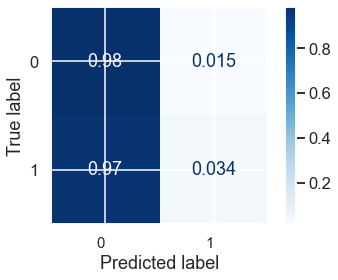

In [23]:
plt.figure(figsize =(10,10))
plot_confusion_matrix(categ_pipeline, x_test, y_test,
                     cmap=plt.cm.Blues,normalize='true')

plt.xticks(horizontalalignment='right', fontsize='small')
plt.show()

In [24]:
residuals = y_train == train_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     8780
False    3354
Name: final_result, dtype: int64


In [25]:
residuals = y_test == test_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     2906
False    1139
Name: final_result, dtype: int64


**Model Results:**
* There is no overfitting since model evaluation scores for train and test splits are close enough to each other.
* From confusion matrix it is clear that model predicting most of the outcomes as "Pass", due to class imbalance
* About 1/3 of outcomes were predicted falsely based on residuals

## Logistic Regression with Upsampled Data

Since the classes of the target are imbalanced,  will use SMOTE() to upsample data.

In [26]:
upsample_pipe = make_pipeline(transformer, StandardScaler(with_mean = False), 
                              SMOTE(random_state = 2021), 
                              LR(C=0.01, random_state=2021))

upsample_pipe.fit(x_train, y_train)
upsample_pipe.score(x_test, y_test)

history.report(upsample_pipe,x_train, y_train, 'Logistic Regression', 
               'Logistic Regression with Upsampled Data')

Average Accuracy Score: 0.5943641169048651
Average Recall Score: 0.5881920480181895
Average Precision Score: 0.3606393267528933
Average F1 Score: 0.44694544710481693


In [27]:
train_preds = upsample_pipe.predict(x_train)
test_preds = upsample_pipe.predict(x_test)

In [28]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

Precision Score: 0.6746453195626928
Recall Score: 0.5979067084226142
Accuracy Score: 0.5979067084226142
F1 Score: 0.6182357510526185


Precision Score: 0.677889805650391
Recall Score: 0.596044499381953
Accuracy Score: 0.596044499381953
F1 Score: 0.616498506975775




<Figure size 720x720 with 0 Axes>

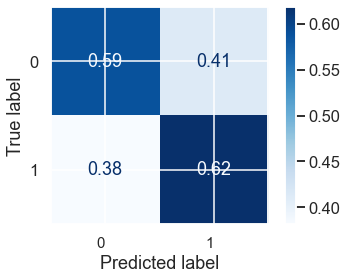

In [29]:
plt.figure(figsize =(10,10))
plot_confusion_matrix(upsample_pipe, x_test, y_test,
                     cmap=plt.cm.Blues,normalize='true')

plt.xticks(horizontalalignment='right', fontsize='small')
plt.show()

In [30]:
residuals = y_train == train_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     7255
False    4879
Name: final_result, dtype: int64


In [31]:
residuals = y_test == test_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     2411
False    1634
Name: final_result, dtype: int64


**Model Results:**

* Upsampled model performed worse than imbalanced data in terms of evaluation metrics
* The confusion matrix shows better performance in term of high diagonal values.
* The value of false negative got down

## Grid Search for C Value

In [32]:
C = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

parameters = dict(logisticregression__C=C)

clf_GS = GridSearchCV(upsample_pipe, parameters)

clf_GS.fit(x_train, y_train)


print('Best C:', clf_GS.best_estimator_.get_params()['logisticregression__C'])

Best C: 0.05


In [33]:
lr_pipe_2 = make_pipeline(transformer, StandardScaler(with_mean = False), SMOTE(),
                              LR(C=clf_GS.best_estimator_.get_params()['logisticregression__C'],
                                                 random_state=2021, max_iter = 5000))
lr_pipe_2.fit(x_train, y_train)
lr_pipe_2.score(x_test, y_test)

0.5928306551297898

In [34]:
history.report(lr_pipe_2,x_train, y_train, 'Logistic Regression', 
               'Regression with All Features and Best C - Value')

Average Accuracy Score: 0.591726844413418
Average Recall Score: 0.5879385707038562
Average Precision Score: 0.35839601965588913
Average F1 Score: 0.44518976487074413


In [35]:
train_preds = lr_pipe_2.predict(x_train)
test_preds = lr_pipe_2.predict(x_test)

In [36]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

Precision Score: 0.6747050752827987
Recall Score: 0.5970825778803363
Accuracy Score: 0.5970825778803363
F1 Score: 0.6174967442439127


Precision Score: 0.6763031872672706
Recall Score: 0.5928306551297898
Accuracy Score: 0.5928306551297898
F1 Score: 0.6134902619423326




<Figure size 720x720 with 0 Axes>

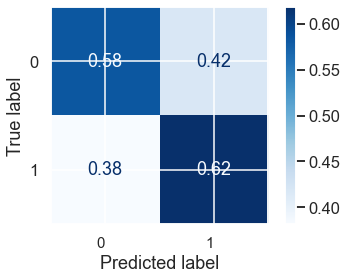

In [37]:
plt.figure(figsize =(10,10))
plot_confusion_matrix(lr_pipe_2, x_test, y_test,
                     cmap=plt.cm.Blues,normalize='true')

plt.xticks(horizontalalignment='right', fontsize='small')
plt.show()

### Model Results:
* Model Performed same as Upsampled Logistic Regression in terms of metrics
* Confusion Matrix shows same value for false negatives

## K Nearest Neighbors

In [52]:
knn_pipeline = make_pipeline(transformer, StandardScaler(with_mean = False), 
                             SMOTE(), KNN())



In [53]:
history.report(knn_pipeline,x_train, y_train, 'KNN - Defaults', 
               'KNN with All Features')

Average Accuracy Score: 0.5710394395694094
Average Recall Score: 0.45816287159497315
Average Precision Score: 0.31519496400538133
Average F1 Score: 0.37335347524010304


In [54]:
knn_pipeline.fit(x_train, y_train)
knn_pipeline.score(x_test, y_test)

0.5859085290482077

In [55]:
train_preds = knn_pipeline.predict(x_train)
test_preds = knn_pipeline.predict(x_test)

In [56]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

Precision Score: 0.768541188615851
Recall Score: 0.7389154442063622
Accuracy Score: 0.7389154442063622
F1 Score: 0.7481762186110825


Precision Score: 0.634668205148622
Recall Score: 0.5859085290482077
Accuracy Score: 0.5859085290482077
F1 Score: 0.6032380167010051




<Figure size 720x720 with 0 Axes>

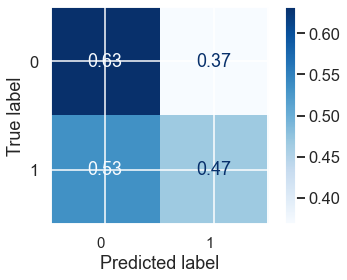

In [57]:
plt.figure(figsize =(10,10))
plot_confusion_matrix(knn_pipeline, x_test, y_test,
                     cmap=plt.cm.Blues,normalize='true')

plt.xticks(horizontalalignment='right', fontsize='small')
plt.show()

In [58]:
residuals = y_train == train_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     8966
False    3168
Name: final_result, dtype: int64


In [59]:
residuals = y_test == test_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     2370
False    1675
Name: final_result, dtype: int64


### Model Results:
* Model is overfitting training data based on metrics
* Confusion matrix on test sets shows increased valur for false negatives

## Decision Tree Model

In [ ]:
dt_pipeline = make_pipeline(transformer, StandardScaler(with_mean = False), 
                             SMOTE(), DT(random_state = 2021))

In [ ]:
history.report(dt_pipeline,x_train, y_train, 'Decision Tree - Defaults', 
               'Decision Tree with All Features')

In [ ]:
dt_pipeline.fit(x_train, y_train)
dt_pipeline.score(x_test, y_test)

In [ ]:
train_preds = dt_pipeline.predict(x_train)
test_preds = dt_pipeline.predict(x_test)

In [ ]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

In [ ]:
plt.figure(figsize =(10,10))
plot_confusion_matrix(dt_pipeline, x_test, y_test,
                     cmap=plt.cm.Blues,normalize='true')

plt.xticks(horizontalalignment='right', fontsize='small')
plt.show()

In [ ]:
residuals = y_train == train_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

In [ ]:
residuals = y_test == test_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

### Max Depth of Tree

In [ ]:
max_depths = np.linspace(1, 15, 15, endpoint=True)
train_results = []
test_results = []

for max_depth in max_depths:
    
    dt_depth_p = make_pipeline(transformer, StandardScaler(with_mean = False), 
                             SMOTE(), DT( max_depth=max_depth,
                                         random_state = 1))
    dt_depth_p.fit(x_train, y_train)
    train_pred = dt_depth_p.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous train results
    train_results.append(roc_auc)
    y_pred = dt_depth_p.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous test results
    test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(max_depths, train_results, 'b', label='Train AUC')
plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.ylabel('AUC Score')
plt.xlabel('Tree Depth')
plt.legend()
plt.show()

In [ ]:
# Max depth 5 or 7

In [ ]:
dt_pipe_2 = make_pipeline(transformer, StandardScaler(with_mean = False), 
                             SMOTE(), DT(random_state = 2021, max_depth = 7))

In [ ]:
history.report(dt_pipe_2,x_train, y_train, 'Decision Tree - Depth 9', 
               'Decision Tree with Max Depth of 9')

In [ ]:
dt_pipe_2.fit(x_train, y_train)
dt_pipe_2.score(x_test, y_test)

In [ ]:
train_preds = dt_pipe_2.predict(x_train)
test_preds = dt_pipe_2.predict(x_test)

In [ ]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

In [ ]:
plt.figure(figsize =(10,10))
plot_confusion_matrix(dt_pipe_2, x_test, y_test,
                     cmap=plt.cm.Blues,normalize='true')

plt.xticks(horizontalalignment='right', fontsize='small')
plt.show()

In [ ]:
residuals = y_train == train_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

In [ ]:
residuals = y_test == test_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

### Improved

## Random Forest Model

In [ ]:
rf_pipeline = make_pipeline(transformer, StandardScaler(with_mean = False), 
                             SMOTE(), RFC(max_depth = 7, random_state = 2021))

In [ ]:
history.report(rf_pipeline,x_train, y_train, 'Random Forest - Defaults', 
               'Random Forest with All Features')

In [ ]:
rf_pipeline.fit(x_train, y_train)
rf_pipeline.score(x_test, y_test)

In [ ]:
train_preds = rf_pipeline.predict(x_train)
test_preds = rf_pipeline.predict(x_test)

In [ ]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

In [ ]:
plt.figure(figsize =(10,10))
plot_confusion_matrix(rf_pipeline, x_test, y_test,
                     cmap=plt.cm.Blues,normalize='true')

plt.xticks(horizontalalignment='right', fontsize='small')
plt.show()

In [ ]:
residuals = y_train == train_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

In [ ]:
residuals = y_test == test_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

### Improved

## Gradient Boost

In [ ]:
gbc_pipeline = make_pipeline(transformer, StandardScaler(with_mean = False), 
                             SMOTE(), GBC(max_depth = 7, random_state = 2021))

In [ ]:
history.report(gbc_pipeline,x_train, y_train, 'Gradient Boost - Defaults', 
               'Gradient Boost with All Features')

In [ ]:
gbc_pipeline.fit(x_train, y_train)
gbc_pipeline.score(x_test, y_test)

In [ ]:
train_preds = gbc_pipeline.predict(x_train)
test_preds = gbc_pipeline.predict(x_test)

In [ ]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

In [ ]:
plt.figure(figsize =(10,10))
plot_confusion_matrix(gbc_pipeline, x_test, y_test,
                     cmap=plt.cm.Blues,normalize='true')

plt.xticks(horizontalalignment='right', fontsize='small')
plt.show()

In [ ]:
residuals = y_train == train_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

In [ ]:
residuals = y_test == test_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

## XGBoost

In [ ]:
xgb_pipeline = make_pipeline(transformer, StandardScaler(with_mean = False), 
                             SMOTE(), XGB(use_label_encoder=False, verbosity=0))

In [ ]:
history.report(xgb_pipeline,x_train, y_train, 'XGBoost - Defaults', 
               'XGBoost with All Features')

In [ ]:
xgb_pipeline.fit(x_train, y_train)
xgb_pipeline.score(x_test, y_test)

In [ ]:
train_preds = xgb_pipeline.predict(x_train)
test_preds = xgb_pipeline.predict(x_test)

In [ ]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

In [ ]:
plt.figure(figsize =(10,10))
plot_confusion_matrix(xgb_pipeline, x_test, y_test,
                     cmap=plt.cm.Blues,normalize='true')

plt.xticks(horizontalalignment='right', fontsize='small')
plt.show()

In [ ]:
residuals = y_train == train_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

In [ ]:
residuals = y_test == test_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

## Demographic Features Random Forest

In [ ]:
x_train.info()

In [ ]:
labels = ['gender', 'region', 'highest_education', 'imd_band', 
          'age_band', 'attempts', 'studied_credits', 'disability']

x_train_demo = x_train[labels]
x_test_demo = x_test[labels]


In [ ]:
cat_cols = x_train_demo.select_dtypes(include='object').columns
indices = []
for col in cat_cols:
    indices.append(x_train_demo.columns.get_loc(col))

transformer = ColumnTransformer(transformers=[('categorical', 
                                               OneHotEncoder(handle_unknown = 'ignore'), indices)])

In [ ]:
dm_lr_pipe = make_pipeline(transformer, StandardScaler(with_mean = False),SMOTE(), 
                           RFC(max_depth = 7, random_state = 2021))

In [ ]:
history.report(dm_lr_pipe,x_train_demo, y_train, 'random Forest Demographics', 
               'Random Forest with Demographic Features and Best C value')

In [ ]:
dm_lr_pipe.fit(x_train_demo, y_train)
dm_lr_pipe.score(x_test_demo, y_test)

In [ ]:
train_preds = dm_lr_pipe.predict(x_train_demo)
test_preds = dm_lr_pipe.predict(x_test_demo)

In [ ]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

In [ ]:
plt.figure(figsize =(10,10))
plot_confusion_matrix(dm_lr_pipe, x_test_demo, y_test,
                     cmap=plt.cm.Blues,normalize='true')

plt.xticks(horizontalalignment='right', fontsize='small')
plt.show()

In [ ]:
residuals = y_train == train_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

In [ ]:
residuals = y_test == test_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

## Numeric Features 

In [ ]:
x_train.info()

In [ ]:
labels = ['course_length', 'date_registration', 
          'sum_click', 'mean_score']

In [ ]:
x_train_num = x_train[labels]
x_test_num = x_test[labels]

In [ ]:
num_rf_pipe = make_pipeline(StandardScaler(with_mean = False),SMOTE(), 
                           RFC(max_depth = 7, random_state = 2021))

In [ ]:
history.report(num_rf_pipe,x_train_num, y_train, 'Random Forest Course Info', 
               'Random Forest with Course Info Features')

In [ ]:
num_rf_pipe.fit(x_train_num, y_train)
num_rf_pipe.score(x_test_num, y_test)

In [ ]:
train_preds = num_rf_pipe.predict(x_train_num)
test_preds = num_rf_pipe.predict(x_test_num)

In [ ]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

In [ ]:
plt.figure(figsize =(10,10))
plot_confusion_matrix(num_rf_pipe, x_test_num, y_test,
                     cmap=plt.cm.Blues,normalize='true')

plt.xticks(horizontalalignment='right', fontsize='small')
plt.show()

In [ ]:
residuals = y_train == train_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

In [ ]:
residuals = y_test == test_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

## Numeric and Some Demographic Features

In [ ]:
labels = ['gender', 'highest_education', 
          'imd_band', 'age_band', 'course_length', 
          'date_registration', 'sum_click', 'mean_score']

In [ ]:
x_train_both = x_train[labels]
x_test_both = x_test[labels]

In [ ]:
cat_cols = x_train_both.select_dtypes(include='object').columns
indices = []
for col in cat_cols:
    indices.append(x_train_both.columns.get_loc(col))

transformer = ColumnTransformer(transformers=[('categorical', 
                                               OneHotEncoder(handle_unknown = 'ignore'), indices)])

In [ ]:
dt_both_pipe = make_pipeline(transformer, StandardScaler(with_mean = False),SMOTE(), 
                           RFC(max_depth = 7, random_state = 2021))

In [ ]:
history.report(dt_both_pipe,x_train_both, y_train, 'Random Forest Some Demographics ans Numeric', 
               'Random Forest with Some Demographic and Numeric Features')

In [ ]:
dt_both_pipe.fit(x_train_both, y_train)
dt_both_pipe.score(x_test_both, y_test)

In [ ]:
train_preds = dt_both_pipe.predict(x_train_both)
test_preds = dt_both_pipe.predict(x_test_both)

In [ ]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

In [ ]:
plt.figure(figsize =(10,10))
plot_confusion_matrix(dt_both_pipe, x_test_both, y_test,
                     cmap=plt.cm.Blues,normalize='true')

plt.xticks(horizontalalignment='right', fontsize='small')
plt.show()

In [ ]:
residuals = y_train == train_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

In [ ]:
residuals = y_test == test_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

## Feature Importance Logistic Regression

In [ ]:
upsample_pipe[3].coef_